In [1]:
!pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download g2net-gravitational-wave-detection

100% 69.0G/69.0G [07:51<00:00, 226MB/s]
100% 69.0G/69.0G [07:51<00:00, 157MB/s]


In [6]:
! mkdir g2net-gw

In [ ]:
! unzip g2net-gravitational-wave-detection.zip -d g2net-gw

In [8]:
!pip install nnAudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.1 MB/s eta 0:00:00


In [9]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.metrics import AUC

import librosa.display
import torch

# this is used for Contant Q Transform
from nnAudio.Spectrogram import CQT1992v2
from tensorflow.keras.applications import EfficientNetB0 as efn

In [10]:
train_labels = pd.read_csv("/content/g2net-gw/training_labels.csv")
train_labels.head()

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


In [11]:
train_path = glob("/content/g2net-gw/train/*/*/*/*")

In [12]:
# get the list of ids from the .npy files
ids_from_npy_files = [path.split("/")[-1].split(".")[0] for path in train_path]

# get a dataframe with paths and ids of those .npy files
df_path_id = pd.DataFrame({'path': train_path, 'id':ids_from_npy_files})

# merging that above df with the target
df_train = pd.merge(left=train_labels, right=df_path_id, on='id')
display(df_train.head())

# verifying the shape of the merged df has 5,60,000 rows and 3 columns
print(df_train.shape)


,id,target,path
0,00000e74ad,1,/content/g2net-gw/train/0/0/0/00000e74ad.npy
1,00001f4945,0,/content/g2net-gw/train/0/0/0/00001f4945.npy
2,0000661522,0,/content/g2net-gw/train/0/0/0/0000661522.npy
3,00007a006a,0,/content/g2net-gw/train/0/0/0/00007a006a.npy
4,0000a38978,1,/content/g2net-gw/train/0/0/0/0000a38978.npy


(560000, 3)


In [13]:
# CQT
transform = CQT1992v2(sr=2048,        # sample rate
                fmin=20,        # min freq
                fmax=500,      # max freq
                hop_length=64,  # hop length
                verbose=False)


def preprocess_function_cqt(path):
    signal = np.load(path.numpy())
    for i in range(signal.shape[0]):
        signal[i] /= np.max(signal[i]) # normalize signal

    signal = np.hstack(signal) # horizontal stack
    signal = torch.from_numpy(signal).float() # tensor conversion
    image = transform(signal) # getting the image from CQT transform
    image = np.array(image) # converting to array from tensor
    image = np.transpose(image,(1,2,0)) # transpose the image to get right orientation
    return tf.convert_to_tensor(image)


In [14]:
def preprocess_function_parse_tf(path, y=None):
    [x] = tf.py_function(func=preprocess_function_cqt, inp=[path], Tout=[tf.float32])
    x = tf.ensure_shape(x, input_shape)
    if y is None:
        return x
    else:
        return x,y

def get_npy_filepath(id_, is_train=True):
    path = ''
    if is_train:
        return f'/content/g2net-gw/train/{id_[0]}/{id_[1]}/{id_[2]}/{id_}.npy'
    else:
        return f'/content/g2net-gw/test/{id_[0]}/{id_[1]}/{id_[2]}/{id_}.npy'

In [32]:
input_shape = (56, 193, 1)
batch_size = 250
X = df_train['id']
y = df_train['target'].astype('int8').values
x_train, x_valid, y_train, y_valid = train_test_split(X, y, random_state = 42, stratify = y)

In [33]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train.apply(get_npy_filepath).values, y_train))
# shuffle the dataset
train_dataset = train_dataset.shuffle(len(x_train))
train_dataset = train_dataset.map(preprocess_function_parse_tf, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid.apply(get_npy_filepath).values, y_valid))
valid_dataset = valid_dataset.map(preprocess_function_parse_tf, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l1_l2

def add_dense_block(units, model, layer_name, reg_strength=0.01, dropout_rate=0.5):
    model.add(Dense(units=units, activation='relu',
                    kernel_regularizer=l1_l2(l1=reg_strength, l2=reg_strength),
                    name=layer_name))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

# Instantiate the Sequential model
model_dnn = Sequential(name='DNN_model2')

# Add the Flatten layer to input 2D data
model_dnn.add(Flatten(input_shape=input_shape, name='Flatten'))

# Add Dense layers with Batch Normalization and Dropout
add_dense_block(512, model_dnn, 'Dense_01')
add_dense_block(256, model_dnn, 'Dense_02')
add_dense_block(128, model_dnn, 'Dense_03')
add_dense_block(64, model_dnn, 'Dense_04')

# Add the final Output layer
model_dnn.add(Dense(1, activation='sigmoid', name='Output'))

# Compile the model
model_dnn.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=[[AUC(), 'accuracy']])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Fit the model
history_dnn = model_dnn.fit(x=train_dataset,
                            epochs=5,
                            validation_data=valid_dataset,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=1)


Epoch 1/5
23/23 [==============================] - 2870s 130s/step - loss: 682.2528 - auc_1: 0.4957 - accuracy: 0.5009 - val_loss: 618.6062 - val_auc_1: 0.4919 - val_accuracy: 0.4999
Epoch 2/5
23/23 [==============================] - 2932s 133s/step - loss: 567.5285 - auc_1: 0.5092 - accuracy: 0.5082 - val_loss: 510.3622 - val_auc_1: 0.4965 - val_accuracy: 0.4999
Epoch 3/5
23/23 [==============================] - 2872s 130s/step - loss: 464.8964 - auc_1: 0.4995 - accuracy: 0.4991 - val_loss: 414.2342 - val_auc_1: 0.5002 - val_accuracy: 0.4999
Epoch 4/5
23/23 [==============================] - 2854s 130s/step - loss: 374.4113 - auc_1: 0.5027 - accuracy: 0.5063 - val_loss: 330.3162 - val_auc_1: 0.4970 - val_accuracy: 0.4999
Epoch 5/5
23/23 [==============================] - 2918s 133s/step - loss: 296.0862 - auc_1: 0.5098 - accuracy: 0.5130 - val_loss: 258.4658 - val_auc_1: 0.4964 - val_accuracy: 0.4999


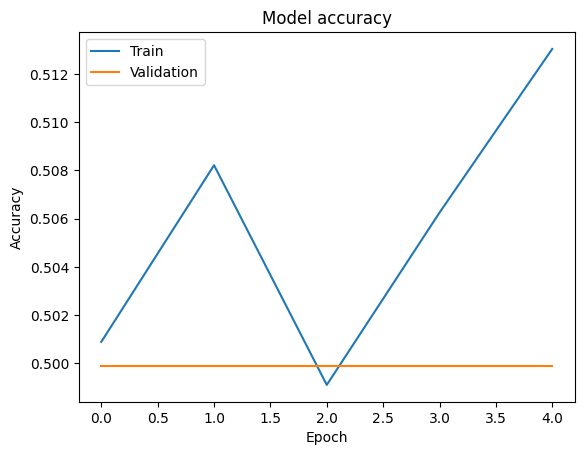

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_dnn.history['accuracy'])
plt.plot(history_dnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l1_l2

def add_dense_block(units, model, layer_name, reg_strength=0.01, dropout_rate=0.5):
    model.add(Dense(units=units, activation='relu',
                    kernel_regularizer=l1_l2(l1=reg_strength, l2=reg_strength),
                    name=layer_name))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

# Instantiate the Sequential model
model_dnn = Sequential(name='DNN_model2')

# Add the Flatten layer to input 2D data
model_dnn.add(Flatten(input_shape=input_shape, name='Flatten'))

# Add Dense layers with Batch Normalization and Dropout
add_dense_block(512, model_dnn, 'Dense_01')
add_dense_block(256, model_dnn, 'Dense_02')
add_dense_block(128, model_dnn, 'Dense_03')
add_dense_block(64, model_dnn, 'Dense_04')

# Add the final Output layer
model_dnn.add(Dense(1, activation='sigmoid', name='Output'))

# Compile the model
model_dnn.compile(optimizer=Adam(learning_rate=0.01),
                  loss='binary_crossentropy',
                  metrics=[[AUC(), 'accuracy']])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Fit the model
history_dnn = model_dnn.fit(x=train_dataset,
                            epochs=10,
                            validation_data=valid_dataset,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=1)


Epoch 1/10
23/23 [==============================] - 2789s 126s/step - loss: 246.0353 - auc_2: 0.4915 - accuracy: 0.4959 - val_loss: 123.7755 - val_auc_2: 0.4997 - val_accuracy: 0.5001
Epoch 2/10
23/23 [==============================] - 2811s 128s/step - loss: 96.9653 - auc_2: 0.4874 - accuracy: 0.4875 - val_loss: 87.3787 - val_auc_2: 0.5000 - val_accuracy: 0.4999
Epoch 3/10
23/23 [==============================] - 2834s 129s/step - loss: 79.8105 - auc_2: 0.5005 - accuracy: 0.5055 - val_loss: 76.8571 - val_auc_2: 0.5000 - val_accuracy: 0.5001
Epoch 4/10
23/23 [==============================] - 2811s 128s/step - loss: 75.9111 - auc_2: 0.4968 - accuracy: 0.4950 - val_loss: 75.0711 - val_auc_2: 0.5000 - val_accuracy: 0.4999
Epoch 5/10
23/23 [==============================] - 2822s 128s/step - loss: 74.1255 - auc_2: 0.4950 - accuracy: 0.4957 - val_loss: 70.7184 - val_auc_2: 0.5000 - val_accuracy: 0.5001
Epoch 6/10
23/23 [==============================] - 2936s 133s/step - loss: 73.0721 - au

In [30]:
model_dnn.summary()

Model: "DNN_model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten (Flatten)           (None, 10808)             0         
                                                                 
 Dense_01 (Dense)            (None, 512)               5534208   
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 Dense_02 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_9 (Batc  (None, 256)              1024      
 hNormalization)                                        

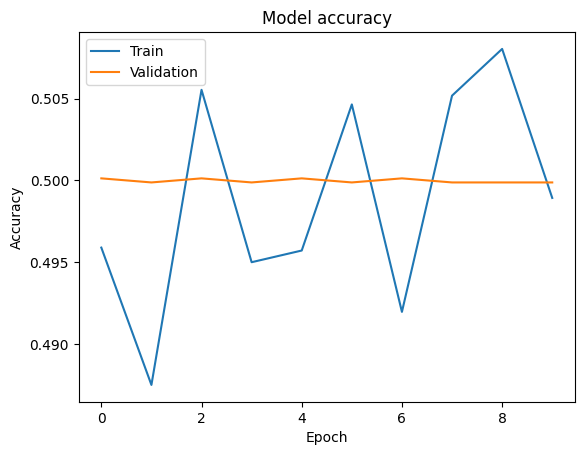

In [28]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_dnn.history['accuracy'])
plt.plot(history_dnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
